# Bayesian Structured Time Series

### The Great NeurIPS 2025 Taco Forecast 🌮

**Location**: San Diego, CA **Objective**: Decompose the latent drivers of Al Pastor consumption.

Welcome to San Diego\! You are attending **NeurIPS 2025**. Between the Deep Learning keynotes and the poster sessions, there is one variable that dominates the conference dynamics: **The hunger for Tacos.**

We suspect that local weather plays a role (San Diegans are notoriously sensitive to the cold), but it implies only part of the story. There are hidden rhythms—weekly cycles, trend shifts, and random shocks—that govern the lines at the taqueria.

In this notebook, we will build a **Bayesian Structured Time Series (STS)** model using `RxInfer.jl` to predict this demand.

This notebook is inspired by the excellent STS repository from [here (sts-jax)](https://github.com/probml/sts-jax).

We are going to extend it by **treating the transition dynamics matrix** (which governs the frequency and damping of these cycles) as a collection of **unknown random variables** and learn them simultaneously with the states. Instead of hard-coding "Taco Tuesday" to exactly 7 days, we let the model discover the rhythm.

## 1\. Setup & Data Generation

We need `RxInfer` for the probabilistic inference and `HTTP` to fetch real San Diego weather data to ground our simulation in reality.

In [2]:
using RxInfer, LinearAlgebra, Statistics, Plots, Lux, StableRNGs
using HTTP, JSON3, DataFrames, CSV, Dates, Random, Distributions

# Professional plotting theme
theme(:wong)

# Reproducibility
rng = StableRNG(42)

println("🌮 Libraries loaded. Preparation for consumption initiated.")

🌮 Libraries loaded. Preparation for consumption initiated.


### The Data: "World Knowledge" Logic

We don't have the actual sales ledger from the taqueria yet, so we will generate a **Taco Demand Index** based on real weather history and some "World Knowledge" assumptions:

1.  **The Patio Curve:** Humans prefer eating tacos outside at 72°F.
2.  **The Rain Penalty:** Rain kills the vibe.
3.  **The Calendar:** Tuesdays and Weekends imply higher demand.

📡 Fetching Real San Diego Weather...
🌮 Generating Demand using World Knowledge Logic...
✅ Data Ready. Training on 987 days.


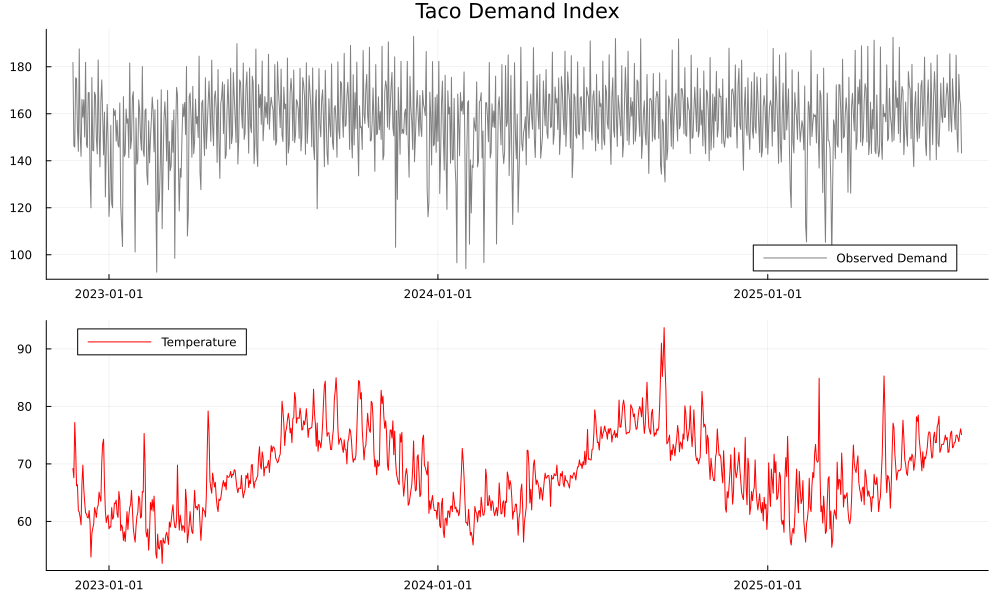

In [42]:
# ==========================================
# 1. FETCH REAL WEATHER DATA
# ==========================================
const LAT = 32.7157
const LON = -117.1611
const START_DATE = Date(today()) - Year(3)
const ARCHIVE_END_DATE = Date(today())

function fetch_real_weather()
    println("📡 Fetching Real San Diego Weather...")
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = Dict(
        "latitude" => LAT, "longitude" => LON,
        "start_date" => string(START_DATE), "end_date" => string(ARCHIVE_END_DATE),
        "daily" => "temperature_2m_max,rain_sum",
        "temperature_unit" => "fahrenheit", "precipitation_unit" => "inch",
        "timezone" => "America/Los_Angeles"
    )
    query_str = join(["$k=$v" for (k,v) in params], "&")
    try
        resp = HTTP.get("$url?$query_str")
        data = JSON3.read(resp.body)
        return DataFrame(
            Date = Date.(String.(data.daily.time)),
            Max_Temp_F = Float64.(data.daily.temperature_2m_max),
            Rain_Inches = Float64.(data.daily.rain_sum)
        )
    catch e
        println("❌ API Error."); rethrow(e)
    end
end

# ==========================================
# 2. GENERATE DEMAND (THE LOGIC)
# ==========================================
function calculate_taco_demand(df::DataFrame)
    println("🌮 Generating Demand using World Knowledge Logic...")
    scores = Float64[]
    for row in eachrow(df)
        d = 150.0
        # Patio Curve
        temp_factor = clamp(1.0 - (abs(row.Max_Temp_F - 72.0)/100.0)^1.5, 0.3, 1.0)
        d *= temp_factor
        # Rain
        rain = row.Rain_Inches
        if rain > 0.5; d -= 40.0; elseif rain > 0.2; d -= 25.0; elseif rain > 0.05; d -= 15.0; end
        # Calendar
        if dayofweek(row.Date) == 2; d += 35.0; end 
        if dayofweek(row.Date) in [5, 6]; d += 20.0;
        elseif dayofweek(row.Date)==7; d += 12.0; end
        
        d += randn() * 5.0 
        push!(scores, clamp(d, 20.0, 250.0))
    end
    df.Taco_Demand_Index = round.(scores, digits=1)
    return df
end

# --- LOAD DATA ---
df_weather_history = fetch_real_weather()
df_history = calculate_taco_demand(deepcopy(df_weather_history))
demand = df_history.Taco_Demand_Index
temperature = df_history.Max_Temp_F
dates = df_history.Date

# Split Train/Test
n_total = length(demand)
n_predict = Int(round(n_total * 0.1)) # Holdout 10% of data
n_train = n_total - n_predict

println("✅ Data Ready. Training on $n_train days.")
p1 = plot(dates[1:n_train], demand[1:n_train], label="Observed Demand", title="Taco Demand Index", color=:gray)
p2 = plot(dates[1:n_train], temperature[1:n_train], label="Temperature", color=:red)
plot(p1, p2, layout=(2,1), size=(1000, 600))

## 2\. The Gaussian STS Model

We define a State Space Model (SSM) with the following full formulation:

$$y_t = H_t z_t + x_t^T \beta + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma_t^2)$$
$$z_{t+1} = F_t z_t + R_t \eta_t, \quad \eta_t \sim N(0, Q_t)$$

### The Latent Dynamics

Our state vector $z_t$ has dimension $D=6$, representing:
`[Level, Daily_Cos, Daily_Sin, Weekly_Cos, Weekly_Sin, AR_Residual]`

#### a\. The Transition Matrix ($F$)

The transition matrix $F$ is constructed from **5 non-zero learnable components** (parameters), which we infer from data. These aren't just static numbers; they represent the physics of seasonality:

  * $F_1, F_2$: Control the **damping** and **rotation frequency** of the **Daily** cycle.
  * $F_3, F_4$: Control the **damping** and **rotation frequency** of the **Weekly** cycle.
  * $F_5$: Controls the decay rate of the **Autoregressive (AR)** trend.

  $$
  F(\theta) = \begin{pmatrix}
  1 & 0 & 0 & 0 & 0 & 0 \\
  0 & F_1 & F_2 & 0 & 0 & 0 \\
  0 & -F_2 & F_1 & 0 & 0 & 0 \\
  0 & 0 & 0 & F_3 & F_4 & 0 \\
  0 & 0 & 0 & -F_4 & F_3 & 0 \\
  0 & 0 & 0 & 0 & 0 & F_5
  \end{pmatrix}
  $$

#### b\. The Selection Matrix ($R$)

$R$ is a selection matrix, which is a subset of columns of the base vector $e_i$. It acts as a bridge, converting the non-singular covariance matrix $Q_t$ (of the lower-dimensional noise $\eta_t$) into the (possibly singular) covariance matrix of the latent state $z_t$.

In our case, we have 4 sources of noise driving 6 states (Level, Daily Base, Weekly Base, AR), so $R$ maps $\mathbb{R}^4 \to \mathbb{R}^6$.

In [4]:
# State Dimension
D = 6
# Observation Matrix: We sum Level(1) + Daily(2) + Weekly(4) + AR(6)
H_vec = [1.0, 1.0, 0.0, 1.0, 0.0, 1.0]

# Transition Function: Dynamically builds M based on parameter F
function transition(F)
    FT = eltype(F)
    M = zeros(FT, 6, 6)
    M[1,1] = one(FT) # Random Walk Trend
    
    # Daily Block (Rotation Matrix)
    M[2,2] = F[1]; M[2,3] = F[2]; 
    M[3,2] = -F[2]; M[3,3] = F[1]
    
    # Weekly Block (Rotation Matrix)
    M[4,4] = F[3]; M[4,5] = F[4]; 
    M[5,4] = -F[4]; M[5,5] = F[3]
    
    # AR Block
    M[6,6] = F[5]
    return M
end

transition (generic function with 1 method)

In [5]:
# The Gaussian STS Model
@model function rxsts(H, X, y, R, priors)
    # Hyperparameters
    τy    ~ priors[:τy]
    β     ~ priors[:β]
    # Prior for the covariance matrix Q
    Q     ~ Wishart(priors[:Q].df, priors[:Q].S)
    η     ~ MvNormal(mean=mean(priors[:η]), precision=Q)
    zprev ~ priors[:z0]
    F     ~ priors[:F] # Learning the 5 non-zero components
    
    for t in eachindex(y)
        # 1. State Transition
        # We use ContinuousTransition because M depends on the random variable F
        z₁[t] ~ ContinuousTransition(zprev, F, diageye(D)) # z₁[t] := F * z₁[t-1]
        z₂[t] ~ R * η
        z[t]  ~ z₁[t] + z₂[t]
        
        # 2. Observation
        μ[t]  ~ dot(H, z[t]) + dot(X[t], β)
        y[t]  ~ Normal(mean = μ[t], precision = τy)
        
        zprev = z[t]
    end
end

In [6]:
# Constraints & Meta
@constraints function rxsts_constraints()
    q(z, z₁, z₂, zprev, F, Q, η, μ, y, τy, β) = q(z, z₁, z₂, zprev)q(F)q(Q)q(η)q(μ, y)q(τy)q(β)
end

@meta function rxsts_meta()
    ContinuousTransition() -> CTMeta(transition)
end

rxsts_meta (generic function with 1 method)

### Inference

We prepare the priors and the $R$ matrix. Note that we center the temperature data (Regressors `X`) so the $\beta$ coefficient is interpretable as deviation from the mean.

In [17]:
# R Matrix: Selection matrix mapping noise to specific states
# Indices 1(Level), 2(Daily), 4(Weekly), 6(AR) get noise.
R = [1 0 0 0; 
     0 1 0 0; 
     0 0 0 0; 
     0 0 1 0; 
     0 0 0 0; 
     0 0 0 1]

# Data Prep
X_input = [[temp] for temp in temperature]
y_input = [demand[1:n_train]; fill(missing, n_predict)]

priors = Dict(
    :τy => GammaShapeRate(10.0, 1.0),
    :β  => MvNormalMeanPrecision(zeros(1), diageye(1)),
    :z0 => MvNormalMeanPrecision(ones(D), diageye(D)),
    :F  => MvNormalMeanPrecision([1.0, 0.1, 0.5, -0.2, 1.0], diageye(5)),
    :Q  => Wishart(6, diagm([1.0, 1.0, 1.0, 1.0])),
    :η  => MvNormalMeanPrecision(zeros(4), diageye(4))
)

@initialization function rxsts_init(priors)
    q(τy) = priors[:τy]; q(F) = priors[:F]; q(Q) = priors[:Q]
    q(η) = priors[:η]; μ(β) = priors[:β]; μ(zprev) = priors[:z0]; μ(z) = priors[:z0]
end

results = infer(
    model = rxsts(H=H_vec, X=X_input, R=R, priors=priors),
    data = (y = y_input,),
    constraints = rxsts_constraints(),
    meta = rxsts_meta(),
    initialization = rxsts_init(priors),
    options = (limit_stack_depth = 100,),
    returnvars = KeepLast(),
    iterations = 15, # VMP Iterations
    showprogress = true
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Inference results:
  Posteriors       | available for (μ, F, τy, z₂, Q, z, β, η, zprev, z₁)
  Predictions      | available for (y)


### Visualization & Decomposition

Let's see if the model discovered "Taco Tuesday" (Weekly Seasonality) and the "Patio Curve" (Beta coefficient) automatically.

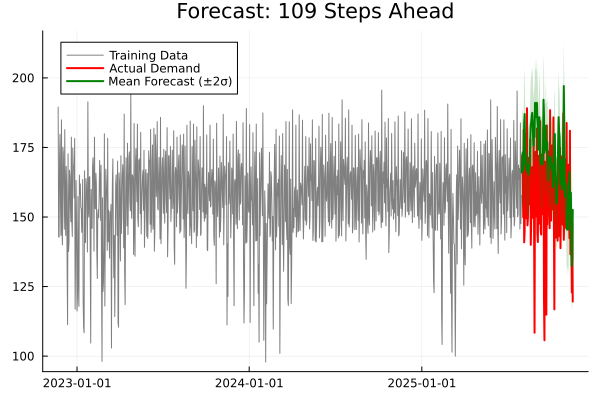

Learned Temperature Coefficient β:  2.244 ± 0.008
Learned Transition Matrix F:


6×6 Matrix{Float64}:
 1.0   0.0        0.0         0.0        0.0       0.0
 0.0   0.0837744  0.282941    0.0        0.0       0.0
 0.0  -0.282941   0.0837744   0.0        0.0       0.0
 0.0   0.0        0.0        -0.332134  -0.153607  0.0
 0.0   0.0        0.0         0.153607  -0.332134  0.0
 0.0   0.0        0.0         0.0        0.0       0.343302

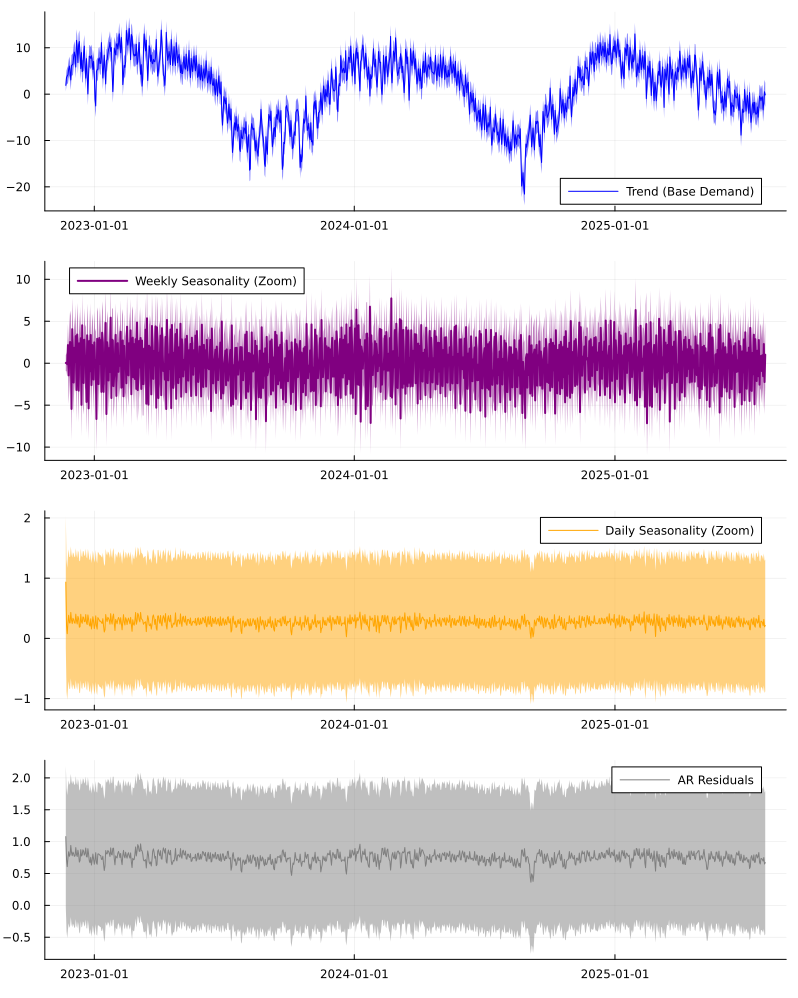

In [ ]:
z_means = mean.(results.posteriors[:z])
z_vars = var.(results.posteriors[:z])
pred_means = mean.(results.predictions[:y][end])
pred_vars = var.(results.predictions[:y][end])

# 1. Forecast Plot
p_forecast = plot(dates[1:n_train], demand[1:n_train], label="Training Data", color=:gray, title="Forecast: $(n_predict) Steps Ahead")
plot!(dates[n_train+1:end], demand[n_train+1:end], label="Actual Demand", color=:red, lw=2)
plot!(dates[n_train+1:end], pred_means[n_train+1:end], ribbon=sqrt.(pred_vars[n_train+1:end]), 
    label="Mean Forecast (±2σ)", color=:green, fillalpha=0.2, lw=2)
display(p_forecast)

# 2. Component Decomposition
level_means  = getindex.(z_means, 1); level_vars = getindex.(z_vars, 1)
daily_means = getindex.(z_means, 2); daily_vars = getindex.(z_vars, 2)
weekly_means = getindex.(z_means, 4); weekly_vars = getindex.(z_vars, 4)
ar_means     = getindex.(z_means, 6); ar_vars     = getindex.(z_vars, 6)

l = @layout [a; b; c; d]
p_trend = plot(dates[1:n_train], level_means[1:n_train], ribbon=sqrt.(level_vars[1:n_train]), label="Trend (Base Demand)", color=:blue)
p_week  = plot(dates[1:n_train], weekly_means[1:n_train], ribbon=sqrt.(weekly_vars[1:n_train]), label="Weekly Seasonality (Zoom)", color=:purple, lw=2)
p_daily = plot(dates[1:n_train], daily_means[1:n_train], ribbon=sqrt.(daily_vars[1:n_train]), label="Daily Seasonality (Zoom)", color=:orange)
p_ar    = plot(dates[1:n_train], ar_means[1:n_train], ribbon=sqrt.(ar_vars[1:n_train]), label="AR Residuals", color=:gray)

plot(p_trend, p_week, p_daily, p_ar, layout=l, size=(800, 1000))

# Extract learned Beta
β_mean = mean(results.posteriors[:β])[1]
β_var  = var(results.posteriors[:β])[1]
println("Learned Temperature Coefficient β:  $(round(β_mean, digits=3)) ± $(round(sqrt(β_var), digits=3))")

# Extract learned F
F_mean = transition(mean(results.posteriors[:F]))
println("Learned Transition Matrix F:")
display(F_mean)

And now! Let's predict some future! For that we need to download some predictions over the next 7 days [Note by the time you read this, it could be way beyond Neurips 2025, or even way beyond 2025 :D] but hope you could still use it for some tacos predictions in San Diego :D

In [46]:
function get_forecast(days::Int)
    println("📡 Fetching Forecast")
    url = "https://api.open-meteo.com/v1/forecast"
    params = Dict(
        "latitude" => LAT, "longitude" => LON,
        "daily" => "temperature_2m_max,rain_sum",
        "temperature_unit" => "fahrenheit",
        "forecast_days" => string(days), 
        "precipitation_unit" => "inch",
        "timezone" => "America/Los_Angeles"
    )
    query = join(["$k=$v" for (k,v) in params], "&")
    resp = HTTP.get("$url?$query")
    data = JSON3.read(resp.body)
    return DataFrame(
        Date = Date.(String.(data.daily.time)),
        Max_Temp_F = Float64.(data.daily.temperature_2m_max),
        Rain_Inches = Float64.(data.daily.rain_sum)
    )
end

get_forecast (generic function with 2 methods)

In [54]:
df_weather_full

Row,Date,Max_Temp_F,Rain_Inches
,Date,Float64,Float64
1,2022-11-22,69.2,0.0
2,2022-11-23,67.6,0.0
3,2022-11-24,77.2,0.0
4,2022-11-25,72.7,0.0
5,2022-11-26,66.2,0.0
6,2022-11-27,66.4,0.0
7,2022-11-28,61.9,0.0
8,2022-11-29,61.6,0.004
9,2022-11-30,60.7,0.0


### Showtime

Now, let's predict the future! We need to download weather forecasts for the next 14 days. (Note: By the time you read this, Neurips 2025 might be ancient history, but hopefully, the code still helps you find the best days for tacos in San Diego!)

In [66]:
days_ahead = 14

df_weather_future  = get_forecast(days_ahead)

df_weather_full = vcat(df_weather_history, df_weather_future)

unique!(df_weather_full, :Date)

df_demand_history = calculate_taco_demand(deepcopy(df_weather_history))
demand_history = df_demand_history.Taco_Demand_Index

temperature_full = df_weather_full.Max_Temp_F
dates_full = df_weather_full.Date;


X_input_future = [[temp] for temp in temperature_full]
y_input_future = [demand_history; fill(missing, days_ahead-1)]

results_future = infer(
    model = rxsts(H=H_vec, X=X_input_future, R=R, priors=priors),
    data = (y = y_input_future,),
    constraints = rxsts_constraints(),
    meta = rxsts_meta(),
    initialization = rxsts_init(priors),
    options = (limit_stack_depth = 100,),
    returnvars = KeepLast(),
    iterations = 15, # VMP Iterations
    showprogress = true
)

📡 Fetching Forecast
🌮 Generating Demand using World Knowledge Logic...


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Inference results:
  Posteriors       | available for (μ, F, τy, z₂, Q, z, β, η, zprev, z₁)
  Predictions      | available for (y)


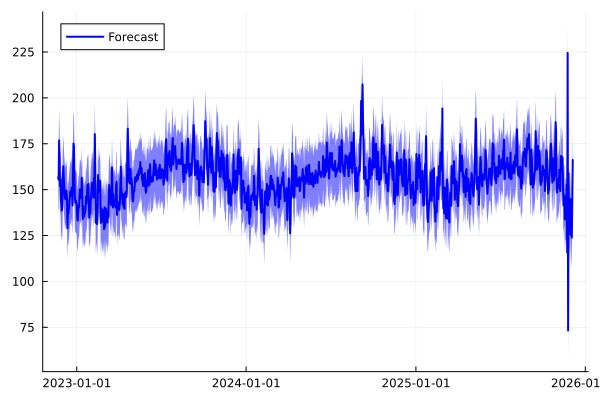

In [ ]:
y_pred_mean = mean.(results_future.predictions[:y][end])
y_pred_var = var.(results_future.predictions[:y][end])

plot(dates_full, y_pred_mean, ribbon=sqrt.(y_pred_var), label="Forecast", color=:blue, lw=2)
plot!(dates_full, demand_history, label="Actual Demand", color=:red, lw=2)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Inference results:
  Posteriors       | available for (μ, F, τy, z₂, Q, z, β, η, zprev, z₁)
  Predictions      | available for (y)


## 3\. Bonus Track: Poisson Likelihood (Counting Tacos)
The Gaussian model assumes demand is continuous. But tacos are discrete integers\!
To handle this, we swap the Likelihood to **Poisson**.
Since Poisson is not conjugate to Gaussian states, we use the **Augmented Poisson** node (Polya-Gamma augmentation) to approximate the posterior.

In [21]:
struct AugmentedPoisson end
@node AugmentedPoisson Stochastic [out , η] 

@rule AugmentedPoisson(:η, Marginalisation) (q_out::PointMass,) = begin
    m_λ = @call_rule Poisson(:l, Marginalisation) (q_out = q_out, )
    samples = rand(m_λ, 1000)
    map!(λ -> log(λ + 1e-6), samples, samples)
    return NormalMeanVariance(mean(samples), var(samples))
end

@rule AugmentedPoisson(:out, Marginalisation) (q_η::GaussianDistributionsFamily,) = begin
    return Poisson(exp(mean(q_η)))
end

# Poisson STS Model
@model function rxsts_poisson(H, X, y, R, priors)
    β  ~ priors[:β]
    Q  ~ priors[:Q]
    η  ~ MvNormal(mean=mean(priors[:η]), precision=Q)
    zprev ~ priors[:z0]
    F     ~ priors[:F]
    for t in eachindex(y)
        z₁[t] ~ ContinuousTransition(zprev, F, diageye(D))
        z₂[t] ~ R * η
        z[t]  ~ z₁[t] + z₂[t]
        μ[t]  ~ dot(H, z[t]) + dot(X[t], β)
        y[t]  ~ AugmentedPoisson(μ[t])
        zprev = z[t]
    end
end

@constraints function rxsts_poisson_constraints()
    q(z, z₁, z₂, zprev, F, Q, η, μ, β, s,y) = q(z, z₁, z₂, zprev, β, η, μ, s,y)q(F)q(Q)
end

@meta function rxsts_poisson_meta()
    ContinuousTransition() -> CTMeta(transition)
end

priors_poisson = Dict(
    :β  => MvNormalMeanPrecision(zeros(1), diageye(1)),
    :z0 => MvNormalMeanPrecision(zeros(D), diageye(D)),
    :F  => MvNormalMeanPrecision(ones(5), diageye(5)),
    :Q  => Wishart(6, diageye(4)),
    :η  => MvNormalMeanPrecision(zeros(4), diageye(4)),
)

@initialization function rxsts_poisson_init(priors)
    q(F)  = priors[:F]
    q(Q)  = priors[:Q]
    μ(z)  = priors[:z0]
    μ(z₁) = priors[:z0]
 
end

X_input = [[temp] for temp in temperature]
y_poisson_in = [round.(Int,demand[1:n_train] ./ 5.0); fill(missing, n_predict)]

results_poi = infer(
    model = rxsts_poisson(H=H_vec, X=X_input, R=R, priors=priors),
    data = (y = y_poisson_in,),
    constraints = rxsts_poisson_constraints(),
    meta = rxsts_meta(),
    initialization = rxsts_poisson_init(priors),
    returnvars = KeepLast(),
    options = (limit_stack_depth = 100,),
    iterations = 10, showprogress = true
)

┌ Warning: Some variables in factorization constraint q(z, z₁, z₂, zprev, F, Q, η, μ, β, s, y) = q(z, z₁, z₂, zprev, β, η, μ, s, y)q(F)q(Q) are not present in the context.
└ @ GraphPPL /Users/apodusenko/.julia/packages/GraphPPL/IVPQ2/src/plugins/variational_constraints/variational_constraints_engine.jl:786
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Inference results:
  Posteriors       | available for (μ, F, z₂, Q, z, β, η, zprev, z₁)
  Predictions      | available for (y)


In [72]:
# Visualize Probability Mass Function (PMF)
y_dists = results_poi.predictions[:y][end]
heatmap(n_train:n_total, 0:maximum(y_poisson_in), 
    (x, y) -> pdf(y_dists[x], y), 
    title="Poisson PMF Forecast", xlabel="Time", ylabel="Count", color=:viridis)

MethodError: MethodError: no method matching (::Colon)(::Int64, ::Missing)
The function `Colon()` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  (::Colon)(::T, ::Any, !Matched::T) where T<:Real
   @ Base range.jl:50
  (::Colon)(::A, ::Any, !Matched::C) where {A<:Real, C<:Real}
   @ Base range.jl:10
  (::Colon)(::T, ::Any, !Matched::T) where T
   @ Base range.jl:49
  ...


## 4\. Bonus Track: Binomial Likelihood (Crowd Rating)

What if we don't have counts, but just a rating of the crowd size (0 stars to 4 stars)?
We use the **Binomial** distribution. This uses Polya-Gamma augmentation implicitly via `BinomialPolya` to handle the Sigmoid link function.

In [73]:
# Map Continuous Demand to Categories (0-4)
function map_to_binomial_data(demand, n_trials)
    y = zeros(Int, length(demand))
    for i in eachindex(demand)
        if demand[i] >= 6.3; y[i] = 4 # Thresholds adapted to scaled demand 
        elseif 6.3 > demand[i] >= 5.3; y[i] = 3
        elseif 5.3 > demand[i] >= 4.3; y[i] = 2
        elseif 4.3 > demand[i] >= 3.3; y[i] = 1
        else; y[i] = 0; end
    end
    return y
end

# Scale demand for mapping (arbitrary scaling for demo)
demand_scaled = demand ./ 30.0 
y_bin = map_to_binomial_data(demand_scaled, 4)
n_trials = 4 * ones(Int, length(y_bin)) # Max 4 stars
y_bin_in = [y_bin[1:n_train]; fill(missing, n_predict)]

# Binomial STS Model
@model function rxsts_binomial(H, X, y, R, priors, n_trials)
    β  ~ priors[:β]
    Q ~ priors[:Q]
    η  ~ MvNormal(mean=mean(priors[:η]), precision=Q)
    zprev ~ priors[:z0]
    F     ~ priors[:F]
    for t in eachindex(y)
        z₁[t] ~ ContinuousTransition(zprev, F, diageye(D))
        z₂[t] ~ R * η
        z[t]  ~ z₁[t] + z₂[t]
        μ[t]  ~ dot(H, z[t]) + dot(X[t], β)
        # Polya-Gamma augmentation handles the Sigmoid link automatically
        y[t]  ~ BinomialPolya(1/X[t][1], n_trials[t], μ[t]) where {
            dependencies = RequireMessageFunctionalDependencies(β = NormalMeanPrecision(0.0, 0.001))}
        zprev = z[t]
    end
end

@constraints function rxsts_binomial_constraints()
    q(z, z₁, z₂, zprev, F, Q, η, μ, β, s) = q(z, z₁, z₂, zprev, β, η, μ, s)q(F)q(Q)
end

@meta function rxsts_meta()
    ContinuousTransition() -> CTMeta(transition)
end


priors_binomial = Dict(
    :β  => MvNormalMeanPrecision(zeros(1), diageye(1)),
    :z0 => MvNormalMeanPrecision(zeros(D), diageye(D)),
    :F  => MvNormalMeanPrecision([1.0, 1.0, 1.0, 1.0, 1.0], diageye(5)),
    :Q  => Wishart(6, diagm([0.1,0.1,0.1, 0.1])),
    :η  => MvNormalMeanPrecision(zeros(4), diageye(4)),
)

@initialization function rxsts_binomial_init(priors)
    q(F)  = priors[:F]
    q(Q)  = priors[:Q]
    μ(z)  = priors[:z0]
    μ(z₁) = priors[:z0]
 
end

results_bin = infer(
    model = rxsts_binomial(H=H_vec, X=X_input, R=R, priors=priors, n_trials=n_trials),
    data = (y = y_bin_in,),
    constraints = rxsts_binomial_constraints(),
    meta = rxsts_meta(),
    initialization = rxsts_binomial_init(priors_binomial),
    returnvars = KeepLast(),
    options = (limit_stack_depth = 100,),
    iterations = 20, showprogress = true
)

BoundsError: BoundsError: attempt to access 1092-element Vector{Vector{Float64}} at index [1093]

In [ ]:

# Visualization
bin_means = mean.(results_bin.predictions[:y][end])
scatter(n_train:n_total, y_bin[n_train:n_total], label="Actual Stars", title="Binomial Rating Forecast")
plot!(n_train:n_total, bin_means[n_train:n_total], label="Predicted Mean", color=:purple, lw=2)